# FAMOUS PERSONALITIES IMAGE CLASSIFIER

<img align="left" width="500" height="400" src="https://drive.google.com/uc?export=view&id=1DS32nPNsNJT2S7TM2BrwGF7sxCZK2gfC">

## Introduction

### In this project we are going to build an image classifier for 10 of world's famous personalities which are listed below.
#### 1.Anushka Sharma (Actress-India)
#### 2.Barack Obama (Former USA President)
#### 3.Bill Gates (Philanthropist)
#### 4.Dalai Lama (Spiritual Leader)
#### 5.Indira Nooyi (CEO-Pepsico)
#### 6.Melinda Gates (Philanthropist)
#### 7.Narendra Modi (Prime Minister of India)
#### 8.Sundar Pichai (CEO-Google)
#### 9.Vikas Khanna (Celebrity Chef)
#### 10.Virat Kohli (Cricketer)
### We will use various machine learning and deep learning techniques like SVM,Logistic Regression,Convolutional Neural Networks(CNN) to build our model.

### The dataset is manually downloaded from different sites like Google Images,Getty Images,Shutterstock etc.

### Overview of Notebook
#### 1.Exploratory Image Analysis¶
#### 2.Load and Manipulate Data
#### 3. Data Preparation for the Model fitting
#### 4. Model fitting and selection
#### 5. Saving the Model    
#### 6. Conclusion.

In [228]:
# importing libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

## 1. Exploratory Image Analysis

### Using Opencv haarcascade to recognize face in an image.

In [229]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')

### Function for getting cropped faces from an image.

In [231]:
# returns an array if the image contains more than one faces
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    roi=[] 
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            roi.append(roi_color)
    return roi

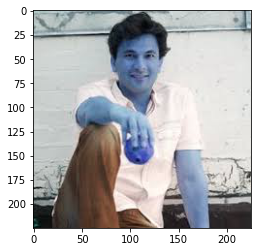

In [232]:
# reading an image
x=r'./test_images/images - 2020-12-16T120442.957.jpg'
original_image=cv2.imread(x)
plt.imshow(original_image)

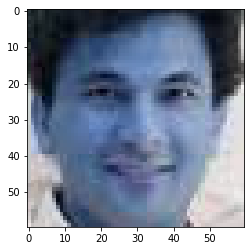

In [233]:
#cropping the face from the image

cropped_image=get_cropped_image_if_2_eyes(x)
for i in range(len(cropped_image)):
    plt.imshow(cropped_image[i])
    


## 2.Load and Manipulate Data

In [234]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [235]:
# dataset folder contains folders of different personalities which are containing raw images
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        
img_dirs

['./dataset/Anushka_Sharma',
 './dataset/Barack_Obama',
 './dataset/Bill_Gates',
 './dataset/Dalai_Lama',
 './dataset/Indira_Nooyi',
 './dataset/Melinda_Gates',
 './dataset/Narendra_Modi',
 './dataset/Sundar_Pichai',
 './dataset/Vikas_Khanna',
 './dataset/Virat_Kohli']

In [236]:
# creating a cropped folder to store cropped face images
import shutil
#  if folder "cropped" exists remove it
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
# create folder
os.mkdir(path_to_cr_data)

### Generating and renaming cropped images

In [237]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
#         print(entry)
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if len(roi_color)!=0:
            for i in range(len(roi_color)):
                cropped_folder = path_to_cr_data + celebrity_name
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder: ",cropped_folder)
                cropped_file_name = celebrity_name + str(count) + ".png"
                
                cropped_file_path = cropped_folder + "/" + cropped_file_name
                cv2.imwrite(cropped_file_path, roi_color[i])
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count +=1

Anushka_Sharma
Generating cropped images in folder:  ./dataset/cropped/Anushka_Sharma
Barack_Obama
Generating cropped images in folder:  ./dataset/cropped/Barack_Obama
Bill_Gates
Generating cropped images in folder:  ./dataset/cropped/Bill_Gates
Dalai_Lama
Generating cropped images in folder:  ./dataset/cropped/Dalai_Lama
Indira_Nooyi
Generating cropped images in folder:  ./dataset/cropped/Indira_Nooyi
Melinda_Gates
Generating cropped images in folder:  ./dataset/cropped/Melinda_Gates
Narendra_Modi
Generating cropped images in folder:  ./dataset/cropped/Narendra_Modi
Sundar_Pichai
Generating cropped images in folder:  ./dataset/cropped/Sundar_Pichai
Vikas_Khanna
Generating cropped images in folder:  ./dataset/cropped/Vikas_Khanna
Virat_Kohli
Generating cropped images in folder:  ./dataset/cropped/Virat_Kohli


In [238]:
img_dirs

['./dataset/Anushka_Sharma',
 './dataset/Barack_Obama',
 './dataset/Bill_Gates',
 './dataset/Dalai_Lama',
 './dataset/Indira_Nooyi',
 './dataset/Melinda_Gates',
 './dataset/Narendra_Modi',
 './dataset/Sundar_Pichai',
 './dataset/Vikas_Khanna',
 './dataset/Virat_Kohli']

## 3. Data Preparation for the Model fitting

In [239]:
# Generating wavelet images for fitting into SVM and Logistic Regression models.

import numpy as np
import pywt
import cv2

def w2d(img,mode='haar',level=1):
    imArray=img
    #Data-type conversion
    #convert to grayscale
    imArray=cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray=np.float32(imArray)
    imArray/=255
    #computeCoefficients
    coeffs=pywt.wavedec2(imArray,mode,level=level)
    
    #process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0]*=0
    
    #reconstruction
    imArray_H=pywt.waverec2(coeffs_H,mode)
    imArray_H*=255
    imArray_H=np.uint8(imArray_H)
    
    return imArray_H


### Storing cropped images names in a dictionary.

In [246]:
celebrity_file_names_dict2={}
for img_dir in img_dirs:
#     print(img_dir)
    celebrity_name = img_dir.split('/')[-1]
#     print(celebrity_name)
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict2[celebrity_name] = file_list
celebrity_file_names_dict2

{'Anushka_Sharma': ['./dataset/Anushka_Sharma\\Anushka_Sharma10.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma105.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma106.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma11.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma110.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma111.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma112.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma113.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma115.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma116.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma117.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma119.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma12.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma120.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma121.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma122.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma124.png',
  './dataset/Anushka_Sharma\\Anushka_Sharma125.png',
  './dataset/Anushka_Sharma\\An

### Dictionary to store classes of different personalities.

In [247]:
class_dict2 = {}
count = 0
for celebrity_name in celebrity_file_names_dict2.keys():
    class_dict2[celebrity_name] = count
    count = count + 1
class_dict2

{'Anushka_Sharma': 0,
 'Barack_Obama': 1,
 'Bill_Gates': 2,
 'Dalai_Lama': 3,
 'Indira_Nooyi': 4,
 'Melinda_Gates': 5,
 'Narendra_Modi': 6,
 'Sundar_Pichai': 7,
 'Vikas_Khanna': 8,
 'Virat_Kohli': 9}

In [248]:
# inverse dictionary
inv_dict2 = dict(zip(class_dict2.values(), class_dict2.keys())) 
inv_dict2

{0: 'Anushka_Sharma',
 1: 'Barack_Obama',
 2: 'Bill_Gates',
 3: 'Dalai_Lama',
 4: 'Indira_Nooyi',
 5: 'Melinda_Gates',
 6: 'Narendra_Modi',
 7: 'Sundar_Pichai',
 8: 'Vikas_Khanna',
 9: 'Virat_Kohli'}

### Creating a vertical stack of raw image and wavelet function generated image and storing in input variable X.

In [211]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict2.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict2[celebrity_name])

C:\Users\tanis\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [212]:
# we have total 2716 images to fit into model
len(X)

2716

In [213]:
# reshaping to 32*32*2 size
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(2716, 4096)

## 4. Model fitting and selection


In [214]:
# fitting into SVM classfier with rbf kernel
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9086892488954345

In [215]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        62
           1       0.84      0.94      0.89        81
           2       0.87      0.87      0.87        55
           3       0.95      0.87      0.91        67
           4       0.97      0.92      0.94        65
           5       0.90      0.94      0.92        87
           6       0.98      0.96      0.97        57
           7       0.96      0.92      0.94        51
           8       0.83      0.89      0.86        70
           9       0.96      0.93      0.95        84

    accuracy                           0.91       679
   macro avg       0.91      0.91      0.91       679
weighted avg       0.91      0.91      0.91       679



### Using GridSearchCV to generate the best model

In [218]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100],
            'svc__kernel': ['rbf','linear']
        }  
    },
    
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [219]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.874811,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,logistic_regression,0.846831,{'logisticregression__C': 1}


In [220]:
best_estimators['svm'].score(X_test,y_test)

0.9086892488954345

In [221]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8630338733431517

### Best Model till now is SVM with 91% test data accuracy.

In [222]:
best_clf = best_estimators['svm']

In [226]:
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma='auto', probability=True))])

In [225]:
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        62
           1       0.84      0.94      0.89        81
           2       0.87      0.87      0.87        55
           3       0.95      0.87      0.91        67
           4       0.97      0.92      0.94        65
           5       0.90      0.94      0.92        87
           6       0.98      0.96      0.97        57
           7       0.96      0.92      0.94        51
           8       0.83      0.89      0.86        70
           9       0.96      0.93      0.95        84

    accuracy                           0.91       679
   macro avg       0.91      0.91      0.91       679
weighted avg       0.91      0.91      0.91       679



### Plotting the confusion matrix

In [223]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[51,  1,  1,  0,  2,  3,  0,  0,  4,  0],
       [ 0, 76,  2,  1,  0,  1,  0,  0,  1,  0],
       [ 0,  1, 48,  1,  0,  1,  0,  0,  4,  0],
       [ 3,  3,  2, 58,  0,  1,  0,  0,  0,  0],
       [ 2,  1,  0,  0, 60,  0,  0,  0,  2,  0],
       [ 1,  2,  0,  0,  0, 82,  1,  0,  1,  0],
       [ 0,  1,  0,  0,  0,  0, 55,  0,  1,  0],
       [ 1,  0,  1,  0,  0,  0,  0, 47,  0,  2],
       [ 0,  2,  1,  1,  0,  3,  0,  0, 62,  1],
       [ 1,  3,  0,  0,  0,  0,  0,  2,  0, 78]], dtype=int64)

Text(69.0, 0.5, 'Truth')

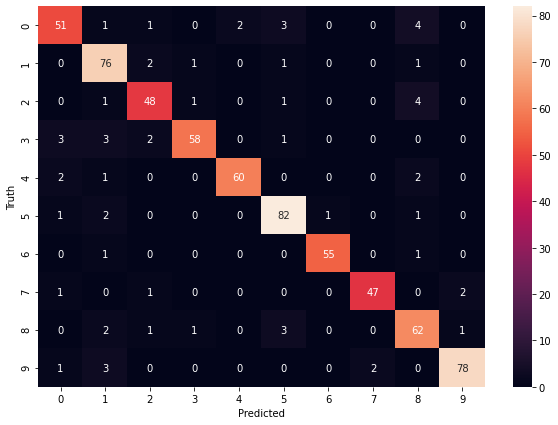

In [224]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Classifying using Convolutional Neural Networks(CNN)

In [268]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict2.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
#         if img is not None:
        scalled_raw_img = cv2.resize(img, (32, 32))
#         img_har = w2d(img,'db1',5)
#         scalled_img_har = cv2.resize(img_har, (32, 32))
#         combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(scalled_raw_img)
        y.append(class_dict2[celebrity_name])

In [269]:
len(X)

2716

In [270]:
X[0]

array([[[ 31,  30,  26],
        [ 31,  30,  26],
        [ 31,  30,  26],
        ...,
        [ 64,  67,  87],
        [ 58,  62,  80],
        [ 52,  56,  74]],

       [[ 31,  30,  26],
        [ 31,  30,  26],
        [ 31,  30,  26],
        ...,
        [ 53,  57,  76],
        [ 64,  68,  86],
        [ 40,  44,  62]],

       [[ 31,  30,  26],
        [ 30,  29,  25],
        [ 29,  28,  24],
        ...,
        [ 47,  55,  75],
        [ 64,  74,  94],
        [ 51,  55,  74]],

       ...,

       [[ 22,  27,  35],
        [ 31,  37,  48],
        [ 15,  21,  34],
        ...,
        [ 21,  26,  32],
        [  7,  12,  11],
        [129, 134, 164]],

       [[ 22,  26,  39],
        [ 32,  37,  52],
        [ 19,  23,  41],
        ...,
        [ 17,  22,  32],
        [  0,   2,   5],
        [163, 168, 198]],

       [[ 32,  34,  51],
        [ 40,  44,  64],
        [ 33,  36,  58],
        ...,
        [  9,  14,  29],
        [  7,  12,  23],
        [184, 189, 219]]

In [271]:
len(X[0])

32

### Changing shape of the input variable array to fit for CNN which requires 4 dimensional array

In [272]:
X = np.array(X).reshape(len(X),32,32,3).astype(float)
X.shape

(2716, 32, 32, 3)

In [273]:
y = np.array(y).reshape(-1).astype(float)
y.shape

(2716,)

In [276]:
X=X/255.0
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)

### Fitting data on CNN model

In [277]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn.fit(X_train, y_train, epochs=40)

Epoch 1/40
68/68 [==============================] - 3s 49ms/step - loss: 2.1137 - accuracy: 0.2523
Epoch 2/40
68/68 [==============================] - 4s 53ms/step - loss: 1.3020 - accuracy: 0.5718
Epoch 3/40
68/68 [==============================] - 4s 55ms/step - loss: 0.7369 - accuracy: 0.7785
Epoch 4/40
68/68 [==============================] - 4s 56ms/step - loss: 0.5392 - accuracy: 0.8476
Epoch 5/40
68/68 [==============================] - 3s 49ms/step - loss: 0.3750 - accuracy: 0.8969
Epoch 6/40
68/68 [==============================] - 3s 48ms/step - loss: 0.3143 - accuracy: 0.9199
Epoch 7/40
68/68 [==============================] - 3s 47ms/step - loss: 0.2669 - accuracy: 0.9291
Epoch 8/40
68/68 [==============================] - 3s 49ms/step - loss: 0.2130 - accuracy: 0.9392
Epoch 9/40
68/68 [==============================] - 4s 53ms/step - loss: 0.1667 - accuracy: 0.9576
Epoch 10/40
68/68 [==============================] - 3s 51ms/step - loss: 0.1472 - accuracy: 0.9632
Epoch 11/

In [278]:
y_pred = cnn.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        49
         1.0       0.95      0.95      0.95        66
         2.0       0.98      0.89      0.93        46
         3.0       0.98      0.90      0.94        51
         4.0       0.98      0.90      0.93        48
         5.0       0.88      0.97      0.92        74
         6.0       0.95      0.93      0.94        45
         7.0       0.93      0.93      0.93        40
         8.0       0.93      0.93      0.93        60
         9.0       0.93      0.97      0.95        65

    accuracy                           0.94       544
   macro avg       0.94      0.93      0.94       544
weighted avg       0.94      0.94      0.94       544



### We can see that test data accuracy using CNN is coming to be 94% which is highest among all our models.Hence finalizing this as the final model for our image classification.

## 5. Saving the Model

In [279]:

cnn.save("my_model.h5") #using h5 extension
print("model saved!!!")

model saved!!!


In [283]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict2))

In [280]:
from keras.models import load_model

model = load_model('my_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                147520    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

## 6.Conclusion

### We got a 91% test case accuracy for SVM model and 94% for CNN model. Hence it again proved that when it comes to image classification CNN works best.
### Now we will deploy the model and create a UI interface to classfiy the images.